#### Setup

In [2]:
import numpy as np
import scipy.io.wavfile
from scipy.fftpack import dct
import scipy.signal
import IPython.display
import librosa
import librosa.display
import matplotlib.pyplot as plt


#### wav to feature2

In [2]:
NFFT = 512
def pre_emphasis(signal, alpha):
    '''
    Return the emphasized signal
    y(t)=x(t)−αx(t−1)
    https://haythamfayek.com/2016/04/21/speech-processing-for-machine-learning.html
    '''
    emphasized_signal = np.append(signal[0], signal[1:] - alpha * signal[:-1])
    return emphasized_signal    
    

#### feature to wav2

In [3]:
def emphasis_reverse(signal, alpha):
    '''
    return the original signal from the istft signal
    x(t) = y(t) + αx(t−1)
    x(0) = y(0)
    '''
    reverse_signal = np.append(signal[0], signal[1:] + alpha*signal[:-1])
    return reverse_signal

Try to run

In [3]:
# file_name = './data/OSR_us_000_0010_8k.wav'
file_name = './4-9_871.wav'
sr, data = scipy.io.wavfile.read(file_name)
print('Sample rate: %d' %sr)

# print(data.shape)
# new_data2 = pre_emphasis(data2,0.97)
# print(new_data2.shape)

feq, times, spect = scipy.signal.stft(data, fs=sr, boundary='zeros', padded=True, nfft=256)
print(spect.shape)

nrows, ncols = spect.shape
spect_sep = np.zeros((2, nrows, ncols))
spect_sep[0, :, :] = spect.real
spect_sep[1, :, :] = spect.imag
print(spect_sep.shape)
spect_comp = spect_sep[0, :, :] + 1j* spect_sep[1, :, :]

_, rdata = scipy.signal.istft(spect_comp, fs=sr, nfft = 256)

# print(times_rever.shape)
print(rdata.shape)
# orig_data = emphasis_reverse(data_rever, 0.97)
# orig_data = data_rever
# print(orig_data - data2)

Sample rate: 22050
(129, 691)
(2, 129, 691)
(88320,)


In [4]:
np.save('./871_spect', spect_sep)

In [5]:
def display(spect, sample_rate, y_axis='mel',x_axis='time'):
    mel_spect = librosa.feature.melspectrogram(S=spect)
    db_data = librosa.power_to_db(mel_spect, ref=np.max)
    librosa.display.specshow(db_data, sr=sample_rate, y_axis=y_axis, x_axis=x_axis)

/home/tianjunm/anaconda3/lib/python3.6/site-packages/librosa/filters.py:284: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '
/home/tianjunm/anaconda3/lib/python3.6/site-packages/librosa/core/spectrum.py:888: UserWarning: power_to_db was called on complex input so phase information will be discarded. To suppress this warning, call power_to_db(np.abs(D)**2) instead.
  warnings.warn('power_to_db was called on complex input so phase '


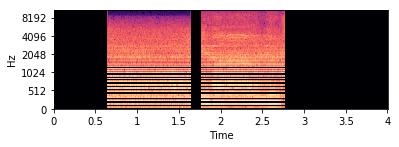

In [6]:
plt.subplot(2, 1, 1)
display(spect, sr*4)

In [32]:
IPython.display.Audio(data=data, rate=sr)

In [33]:
IPython.display.Audio(data=rdata, rate=sr)

In [7]:
sample_rate2, data2 = scipy.io.wavfile.read(file_name)
print('Sample rate: %d' %sample_rate2)

print(data2.shape)
new_data2 = data2
feq, times, stfted = scipy.signal.stft(new_data2, fs = sample_rate2,nperseg=2048)
print(stfted.shape)

times_rever, data_rever = scipy.signal.istft(stfted, fs = sample_rate2, nperseg=2048)

print(times_rever.shape)
print(data_rever.shape)

orig_data = data_rever


IPython.display.Audio(data=orig_data, rate=sample_rate2)

Sample rate: 22050
(88200,)
(1025, 88)
(89088,)
(89088,)


#### feature to wav

In [15]:
N_FFT = 2048
def griffinlim(spectrogram, n_iter=100, window='hann', n_fft=2048,
               hop_length=-1, verbose=False):
    '''audio reconstruction

    Reference: https://github.com/librosa/librosa/issues/434 by Jongwook
    '''

    if hop_length == -1:
        hop_length = n_fft // 4

    angles = np.exp(2j * np.pi * np.random.rand(*spectrogram.shape))

    t = tqdm(range(n_iter), ncols=100, mininterval=2.0, disable=not verbose)
    for i in t:
        full = np.abs(spectrogram).astype(np.complex) * angles
        inverse = librosa.istft(full, hop_length=hop_length, window=window)
        rebuilt = librosa.stft(inverse, n_fft=n_fft,
                               hop_length=hop_length, window=window)
        angles = np.exp(1j * np.angle(rebuilt))

        if verbose:
            diff = np.abs(spectrogram) - np.abs(rebuilt)
            t.set_postfix(loss=np.linalg.norm(diff, 'fro'))

    full = np.abs(spectrogram).astype(np.complex) * angles
    inverse = librosa.istft(full, hop_length=hop_length, window=window)

    return inverse

def reconstruct(spect):
#     n_fft = N_FFT // compress_factor
#     hop_len = N_FFT // 4
    reconstructed_data = griffinlim(spect)
    return reconstructed_data


def playback(data, sample_rate):
    IPython.display.Audio(data=data, rate=sample_rate)

#### wav to feature

In [16]:
def get_spectrogram(data, sample_rate, compress_factor=1):
#     n_frames = len(data)
#     out_frames = n_frames // compress_factor
#     sample_rate_compressed = sample_rate // compress_factor

#     data_compressed = signal.resample(data, out_frames)
    n_fft = N_FFT // compress_factor
    hop_len = N_FFT // 4
    spect = np.abs(librosa.stft(data, n_fft=n_fft, hop_length=hop_len))**2
    
    sample_rate //= compress_factor

#     mel_spect = librosa.feature.melspectrogram(S=spect)
    return (spect, sample_rate)

# def get_spectrogram(data, sample_rate, compress_nfft=1, compress_sr=1):
#     n_frames = len(data)

#     # apply compression during conversion
#     out_frames = n_frames // compress_sr
#     sample_rate_compressed = sample_rate // compress_sr
#     n_fft_compressed = N_FFT // compress_nfft 

#     # compress x-axis 
#     data_compressed = signal.resample(data, out_frames)

#     # compress y-axis
#     spect = np.abs(librosa.stft(data_compressed, n_fft=n_fft_compressed))**2
#     return (spect, sample_rate_compressed)

def display(spect, sample_rate, y_axis='mel', fmax=8000, fmin=0, x_axis='time'):
    mel_spect = librosa.feature.melspectrogram(S=spect)
    db_data = librosa.power_to_db(mel_spect, ref=np.max)
    librosa.display.specshow(db_data, sr=sample_rate, y_axis=y_axis, fmax=fmax, fmin=fmin, x_axis=x_axis)

### scratch

(1025, 173)


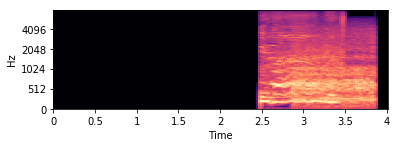

In [17]:
import data.wav2spec as ws

data, sr_in = librosa.load('data/dataset_a1/4-9_1.wav')

# no compression
# spect, sr = ws.get_spectrogram(data, sr_in, compress_factor=1)

spect = np.load('data/a1_spectrograms/1/4-9.npy')
# comp_nfft = 4, comp_rs = 2
# spect_c, sr_c = get_spectrogram(data, sr_in, compress_nfft=4)

print(spect.shape)
# print(spect_c.shape)
plt.subplot(2, 1, 1)
display(spect, sr_in)
# plt.subplot(2, 1, 2)
# display(spect_c, sr_c)

In [21]:
rdata = reconstruct(spect)
# rdata_c = reconstruct(spect_c)

In [19]:
IPython.display.Audio(data=data, rate=sr_in)

In [22]:
IPython.display.Audio(data=rdata, rate=sr)

NameError: name 'sr' is not defined

In [23]:
spect_r, sr_r = get_spectrogram(rdata, sr, compress_factor=1)
# print(spect_c.shape)
plt.subplot(2, 1, 1)
display(spect_r, sr)

NameError: name 'sr' is not defined

In [24]:
IPython.display.Audio(data=rdata_c, rate=sr_c)

NameError: name 'rdata_c' is not defined

In [25]:
# import json
# with open('data/a1_spectrograms/4-9_11.json', 'r') as fjson:
#     info = json.load(fjson)

# spect = np.array(info['spectrogram'])
# sr = info['sample_rate']

spect = np.load('data/test/4-9_1.npy')
sr = int(np.load('data/test/sample_rate.npy'))

print (spect.shape)
# spect = info[1]
rec = reconstruct(spect)
print(sr)
# print(np.min(spect))
display(spect, sr)
plt.imshow(spect**1e-3, aspect='auto')
IPython.display.Audio(data=rec, rate=sr)

FileNotFoundError: [Errno 2] No such file or directory: 'data/test/sample_rate.npy'

In [26]:
import torch
from model import dataset

In [27]:
d = dataset.SignalDataset(root_dir='data/a1_spectrograms/')

In [28]:
a = d[0]

In [36]:
agg = a['aggregate']
gts = a['ground_truths']

In [37]:
agg.shape

torch.Size([1025, 173])

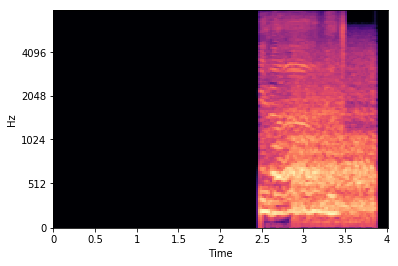

In [38]:
# agg = agg.numpy()
display(agg, 22050)

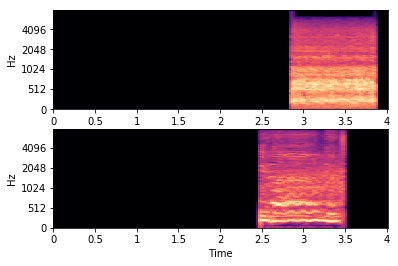

In [39]:
plt.subplot(2, 1, 1)
display(gts[0], 22050)
plt.subplot(2, 1, 2)
display(gts[1], 22050)

In [41]:
rec = reconstruct(agg.numpy())
IPython.display.Audio(data=rec, rate=22050)

In [42]:
rec_g1 = reconstruct(gts[1].numpy())
IPython.display.Audio(data=rec_g1, rate=22050)

### deprecated

(128, 87)
(1025, 87)


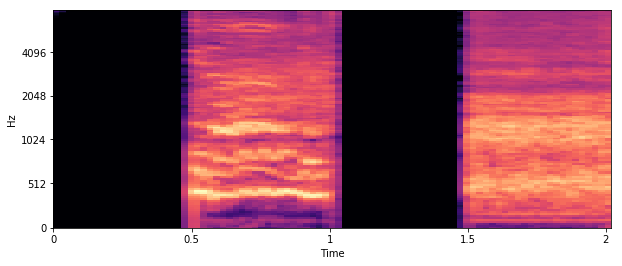

In [132]:
duration = 4
n_frames = sr * duration

# downscale
y_down = signal.resample(y, n_frames//2)
Dc = np.abs(librosa.stft(y_down))**2
Sc = librosa.feature.melspectrogram(S=Dc)

print(Sc.shape)
print(Dc.shape)

plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.power_to_db(Sc, ref=np.max), y_axis='mel', fmax=8000, x_axis='time')


In [134]:
y_fked_inverted = griffinlim(Dc)

In [136]:
IPython.display.Audio(data=y_fked_inverted, rate=sr//2) # play the audio

In [280]:
# print (D.shape)
y_inverted = griffinlim(D)

In [231]:
IPython.display.Audio(data=y_inverted, rate=sr) # play the audio

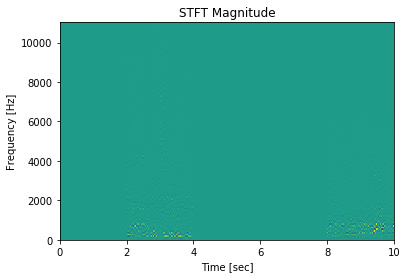

In [179]:
f, t, Zxx = signal.stft(x, fs=fs)
# print(Zxx.real)
plt.pcolormesh(t, f, Zxx.real)
plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

(129, 1724)
(220544,)


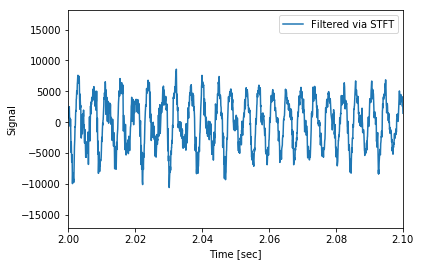

In [152]:
# Zxx = np.where(np.abs(Zxx) >= amp/10, Zxx, 0)
_, xrec = signal.istft(Zxx, fs)
print(Zxx.shape)
print(xrec.shape)
# carrier = x
time = np.arange(10 * fs) / fs
plt.figure()
plt.plot(time, xrec[:10 * fs])
plt.xlim([2, 2.1])
plt.xlabel('Time [sec]')
plt.ylabel('Signal')
plt.legend(['Filtered via STFT'])
plt.show()

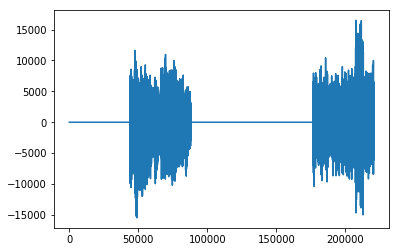

In [113]:
fs, x = wavfile.read(pa)
plt.plot(x)

In [51]:
def plot_spectrogram(info):
    fs, x = info
    plt.specgram(x + 1e-4 * np.random.random(size=x.shape[0]), Fs=fs)

    plt.gca().set_axis_off()
    plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)
    plt.margins(0,0)
    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().yaxis.set_major_locator(plt.NullLocator())

    plt.savefig('trial.png', bbox_inches='tight', pad_inches = 0)

In [37]:
info_agg = get_spectrogram(pa)
info_comp1 = get_spectrogram(p1)
info_comp2 = get_spectrogram(p2)

info_agg_ = get_spectrogram(pa_)
info_comp1_ = get_spectrogram(p1_)
info_comp2_ = get_spectrogram(p2_)

reference for plotting spectrogram: 
* https://pythontic.com/visualization/signals/spectrogram
* https://matplotlib.org/gallery/images_contours_and_fields/specgram_demo.html#sphx-glr-gallery-images-contours-and-fields-specgram-demo-py

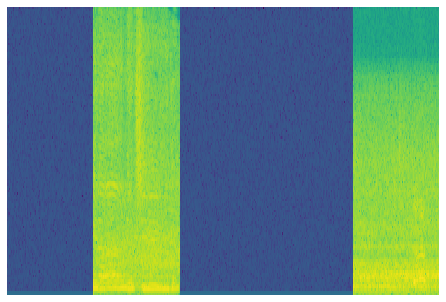

In [52]:
plot_spectrogram(info_agg)
# plot_spectrogram(out)
#make_image(out, 'trial.png')

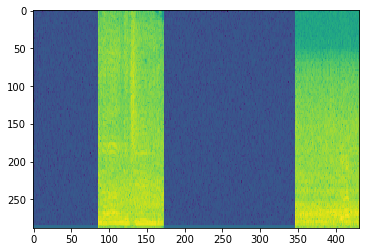

In [55]:
spec = plt.imread('trial.png')

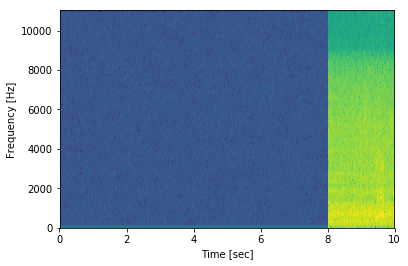

In [67]:
plot_spectrogram(info_comp1)

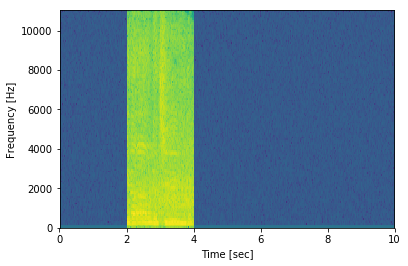

In [68]:
plot_spectrogram(info_comp2)

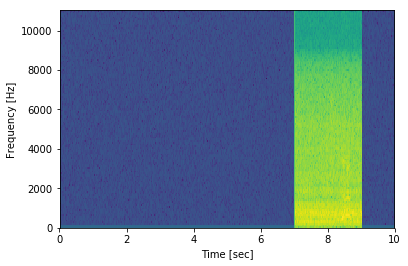

In [60]:
plot_spectrogram(info_comp1_)

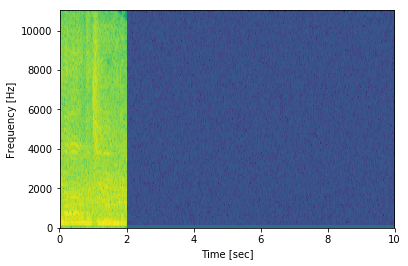

In [61]:
plot_spectrogram(info_comp2_)

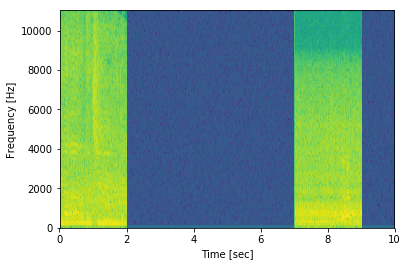

In [62]:
plot_spectrogram(info_agg_)

In [364]:
# pdist = nn.PairwiseDistance(p=2)
# input1 = np.random.randint(1, size=(3, 2))
# input2 = np.random.randint(1, size=(3, 2))
# output = pdist(input1, input2)
a = torch.FloatTensor([[[1,2,3],
                        [1,2,3]],
                       [[4,5,6],
                        [4,5,6]],
                       [[7,8,9],
                        [7,8,9]]])
b = torch.FloatTensor([[1,1,1],
                       [2,2,2]])

# a[:, 0].size()
# b.unsqueeze(0).size()

# a[:, 0] - b
vec = a[:, 0].unsqueeze(1) - b.repeat(3, 1, 1)
print (vec)
print (vec.size())
dist = vec.norm(dim=2)
print (dist)
dist.min(dim=1)
# print (a[:, 0]-b)
# (a-b).norm(dim=1)
# a.size(2
# b.size() # theory of the gundam - scratch for amir yay :D 

tensor([[[ 0.,  1.,  2.],
         [-1.,  0.,  1.]],

        [[ 3.,  4.,  5.],
         [ 2.,  3.,  4.]],

        [[ 6.,  7.,  8.],
         [ 5.,  6.,  7.]]])
torch.Size([3, 2, 3])
tensor([[ 2.2361,  1.4142],
        [ 7.0711,  5.3852],
        [12.2066, 10.4881]])


(tensor([ 1.4142,  5.3852, 10.4881]), tensor([1, 1, 1]))

In [285]:
print (input1)
print (input2)
print (output)

tensor([[[-0.0881, -0.4883,  0.4538,  ..., -0.3541,  0.2713,  0.1697],
         [ 0.3968, -0.1156,  0.0062,  ..., -0.0828,  0.4831, -0.1433],
         [-0.6631, -0.4023, -1.0603,  ..., -0.3527,  0.1603,  0.7508],
         ...,
         [ 1.5117, -0.4010, -2.2277,  ..., -0.0885,  0.8011,  0.0354],
         [-1.8468,  0.5810,  0.6988,  ..., -0.2032, -0.1528,  0.6670],
         [ 0.5594, -0.1852, -1.3296,  ..., -0.1318,  1.3875, -0.3494]],

        [[ 0.3273, -0.5780,  1.9205,  ...,  0.5561, -0.0684, -0.4925],
         [-0.2929, -0.3662, -0.7307,  ..., -1.6579, -0.3053, -0.5426],
         [ 0.4870,  0.3149,  0.9871,  ...,  0.1888, -0.5766, -0.7291],
         ...,
         [ 0.2612,  0.2259,  0.6429,  ...,  0.2293, -1.5037, -0.6791],
         [-0.3218,  1.1649,  1.2309,  ..., -0.1414, -0.6725, -0.1494],
         [-0.1939,  0.3135,  0.5271,  ...,  0.6825,  0.9453, -1.8797]],

        [[-0.9926,  1.9572,  0.0703,  ...,  0.8664,  0.5155, -0.2317],
         [-0.5210,  1.3762, -0.1575,  ..., -0